## US-Upper-Mantle-Vs.Xie.Chu.Yang.2018
Details of the dataset:
- Name: US-Upper-Mantle-Vs.Xie.Chu.Yang.2018
- Title: 3-D Upper-Mantle Shear Velocity Model Beneath the Contiguous United States Based on Broadband Surface Wave from Ambient Seismic Noise
- Type:	3-D tomography Earth Model
- Sub Type: Shear-wave velocity (km/s)
- Year	2018

Author(s): 
- Jun Xie, Risheng Chu, Yingjie Yang

Reference(s):	
  - Jun Xie, Risheng Chu, Yingjie Yang, (2018) 3-D Upper-Mantle Shear Velocity Model Beneath the Contiguous United States Based on Broadband Surface Wave from Ambient Seismic Noise,Pure Appl. Geophys. https://doi.org/10.1007/s00024-018-1881-2

DOI:	doi:10.17611/DP/18299329

Depth Coverage:	60.0 - 300.0 km

Areal Coverage:	Latitude: 28.0 to 49.0 Longitude: -125.0 to -65.0

Model Description:
  - The model is upper mantle Vs model of Contiguous US based on broadband surface waves (10-150s) from ambient seismic noise

Data Set Description:
  - [Xie et al., (2018)](https://doi.org/10.1007/s00024-018-1881-2): The dataset includes shear velocities calculated from the inversion of Rayleigh wave phase velocities determined from ambient noise. Data were primarily collected by the EarthScope USArray.

EMC Page	
  - http://ds.iris.edu/ds/products/emc-us-upper-mantle-vsxiechuyang2018/

## Step0: Downloading & Loading the Source Datasets

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

data_path = "../../../OpenSWI/Datasets/Original/OpenSWI-deep/US-Upper-Mantle-Vs.Xie.Chu.Yang.2018.nc"

# load the .nc file
data = xr.open_dataset(data_path)

# print the keys of the dataset
print(data.keys())

KeysView(<xarray.Dataset>
Dimensions:    (latitude: 45, longitude: 121, depth: 600)
Coordinates:
  * latitude   (latitude) float32 27.5 28.0 28.5 29.0 ... 48.0 48.5 49.0 49.5
  * longitude  (longitude) float32 -125.5 -125.0 -124.5 ... -66.5 -66.0 -65.5
  * depth      (depth) float32 0.0 0.5 1.0 1.5 2.0 ... 298.0 298.5 299.0 299.5
Data variables:
    vs         (depth, latitude, longitude) float32 ...
Attributes: (12/32)
    title:                         3D Upper mantle Shear Velocity Model Benea...
    id:                            US-Upper-Mantle-Vs.Xie.Chu.Yang.2018
    summary:                       This is a upper mantle Vs model of Contigi...
    keywords:                      surface wave, tomography, shear wave, ambi...
    Conventions:                   CF-1.0
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    ...                            ...
    author_email:                  xiejun@apm.ac.cn
    author_institution:            State Key Laboratory of Geo

## Step 1: Velocity Profile Extracting
1. Extracting
2. De-duplicating

In [3]:
latitude = np.array(data['latitude'].values)
longitude = np.array(data['longitude'].values)
depth = np.array(data['depth'].values)
vs = np.array(data['vs'].values)
LON,LAT = np.meshgrid(longitude,latitude)

latitude.shape,longitude.shape,depth.shape,vs.shape

((45,), (121,), (600,), (600, 45, 121))

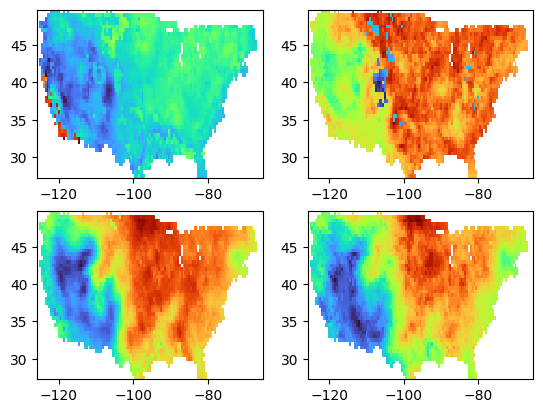

In [4]:
LON,LAT = np.meshgrid(longitude,latitude)

depth_idxs = [50,100,200,300]

fig,axes = plt.subplots(2,2)
for i in range(2):
    for j in range(2):
        axes[i][j].pcolormesh(LON,LAT,vs[depth_idxs[i*2+j]],cmap='turbo')
plt.show()

## Step 2: Quality Control & Interpolation

1. interpolation

2. rationalizing (remove the thin layers)


In [ ]:
import sys
sys.path.append('../../../')
from SWIDP.process_1d_deep import *
from SWIDP.dispersion import *

In [7]:
# ------------------------------------------
# Exclude the invalid values
# ------------------------------------------
vs_valid_1d = vs.reshape(vs.shape[0],-1)
vs_valid_mask = np.sum(~np.isnan(vs_valid_1d),axis=0)>0
vs_valid_1d = vs_valid_1d[:,vs_valid_mask]

vs_valid_1d.shape


(600, 3678)

In [8]:
vs = vs_valid_1d.T
vs.shape

(3678, 600)

In [9]:
# -------------------------------------------------------
#  interpolation
# -------------------------------------------------------
from scipy.interpolate import interp1d
max_depth = 300+0.1
depth_interp = np.concatenate([
    np.arange(0, max_depth, 1)
])
vs_models = vs_interp = np.zeros((vs.shape[0],depth_interp.shape[0]))
for i in range(vs.shape[0]):
    vs_temp = vs[i,:]
    depth_interp_temp = depth_interp[:np.argmin(np.abs(depth_interp-depth.max()))]
    f = interp1d(depth.reshape(-1),vs_temp,kind='nearest')
    vs_temp = f(depth_interp_temp)
    vs_interp[i,:len(vs_temp)] = vs_temp
vs_interp[:,len(vs_temp):] = vs_interp[:,len(vs_temp)-1].reshape(-1,1)
vs_interp.shape

(3678, 301)

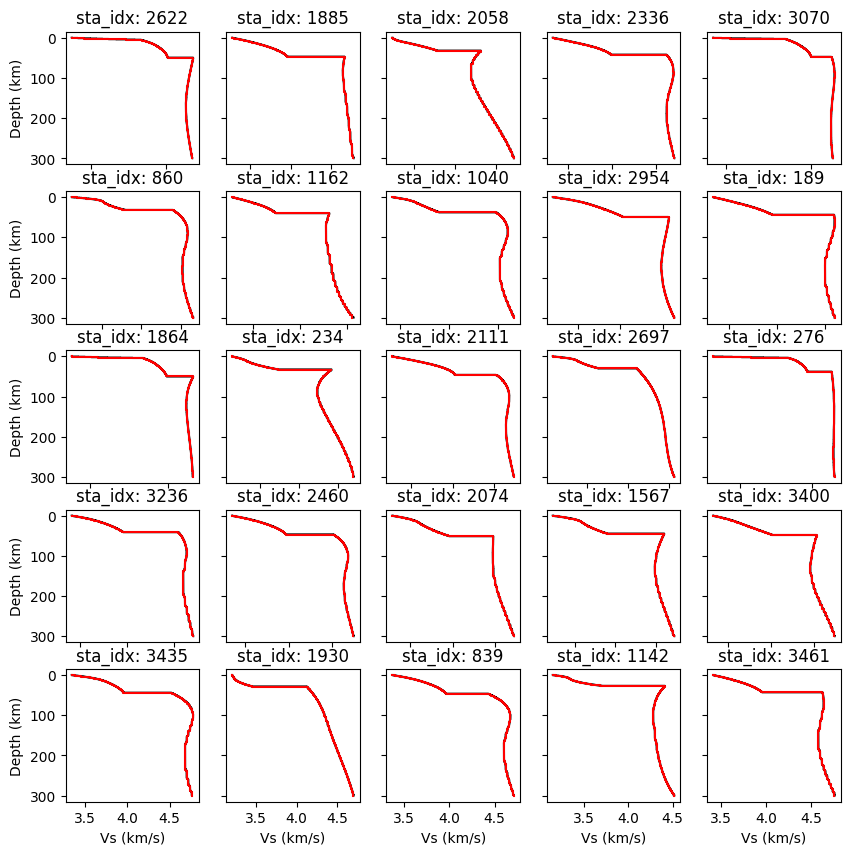

In [10]:
nrows = 5
ncols = 5
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        sta_idx = np.random.randint(0,len(vs))
        axs[i,j].step(vs[sta_idx,:],depth,c='k')
        axs[i,j].step(vs_interp[sta_idx,:],depth_interp,c='r')
        axs[i,j].invert_yaxis()
        axs[i,j].set_title(f'sta_idx: {sta_idx}')
        if j == 0:
            axs[i,j].set_ylabel('Depth (km)')
        else:
            axs[i,j].tick_params(labelleft=False)
        if i == nrows-1:
            axs[i,j].set_xlabel('Vs (km/s)')
        else:
            axs[i,j].tick_params(labelbottom=False)
plt.show()

In [11]:
# -------------------------------------------------------
#  remove the sandwich layers
# -------------------------------------------------------
from p_tqdm import p_map
# process all the stations
vs_interp_rm_sandwich = p_map(combine_thin_sandwich,
                            vs_interp,
                            list(depth_interp.reshape(1,-1))*len(vs_interp),
                            [12]*len(vs_interp),
                            [1]*len(vs_interp),
                            [0.05]*len(vs_interp),
                            [False]*len(vs_interp))

# find the moho depth
vs_interp_rm_sandwich = np.array(vs_interp_rm_sandwich)
vs_interp_rm_sandwich.shape


  0%|          | 0/3678 [00:00<?, ?it/s]

(3678, 301)

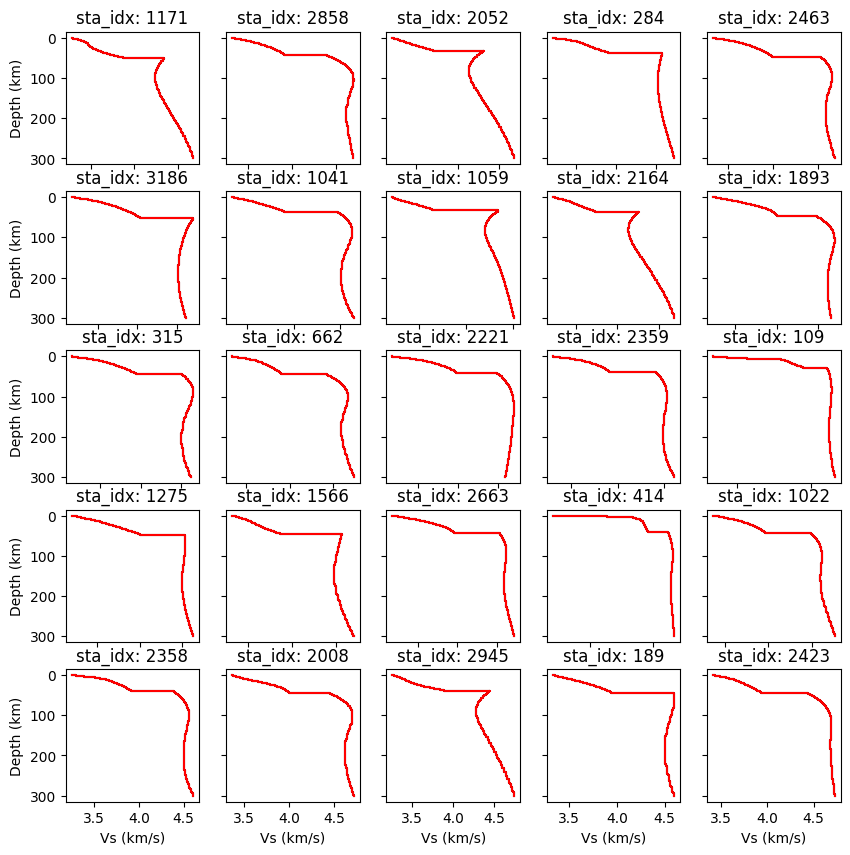

In [12]:
nrows = 5
ncols = 5
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        sta_idx = np.random.randint(0,len(vs))
        axs[i,j].step(vs_interp[sta_idx,:],depth_interp,c='k')
        axs[i,j].step(vs_interp_rm_sandwich[sta_idx,:],depth_interp,c='r')
        axs[i,j].invert_yaxis()
        axs[i,j].set_title(f'sta_idx: {sta_idx}')
        if j == 0:
            axs[i,j].set_ylabel('Depth (km)')
        else:
            axs[i,j].tick_params(labelleft=False)
        if i == nrows-1:
            axs[i,j].set_xlabel('Vs (km/s)')
        else:
            axs[i,j].tick_params(labelbottom=False)
plt.show()

## Step 3: Dispersion Curve Forward Modeling

In [11]:
vs_models = vs_interp_rm_sandwich.reshape(-1,vs_interp_rm_sandwich.shape[-1]) # [n_models,n_depth]
depth_models = list(depth_interp.reshape(1,-1))*len(vs_models)
vel_models = p_map(transform_vs_to_vel_model,vs_models,depth_models)
vel_models = np.array(vel_models)
vel_models.shape

  0%|          | 0/3678 [00:00<?, ?it/s]

(3678, 301, 4)

In [12]:
# Calculate dispersion curves
t = generate_mixed_samples(num_samples=300,start=1,end=100,uniform_num=100,log_num=100,random_num=100)
t = np.ones((len(vel_models),len(t)))*t
disp_data = p_map(calculate_dispersion, vel_models, list(t))
disp_data = np.array(disp_data)
vel_models = np.array(vel_models)
vel_models.shape,disp_data.shape

  0%|          | 0/3678 [00:00<?, ?it/s]

((3678, 301, 4), (3678, 300, 3))

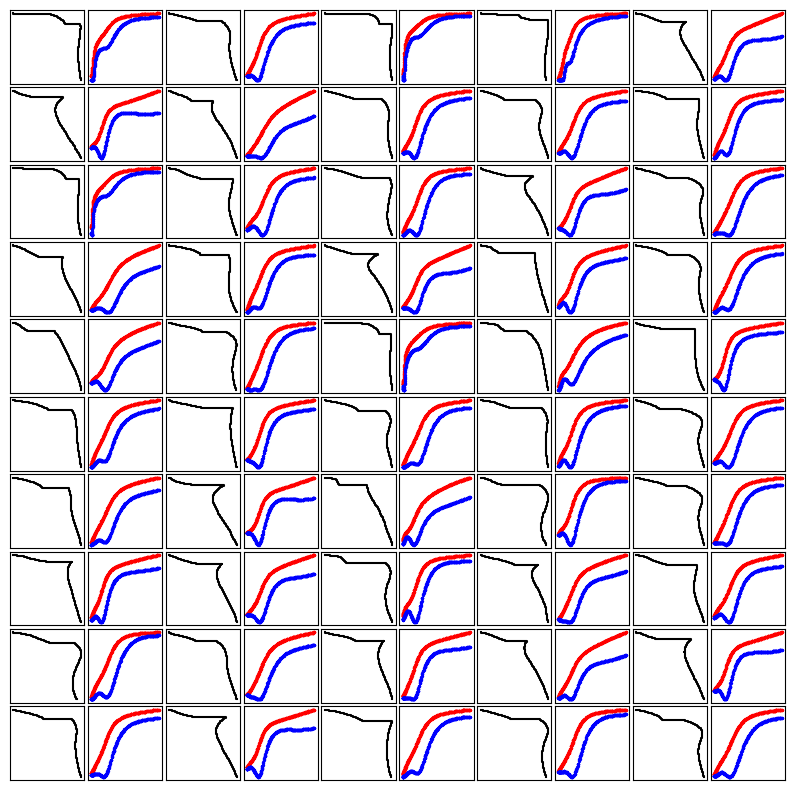

In [13]:
nrows = 10
ncols = 10
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))

for i in range(nrows):
    for j in range(ncols//2):

        sta_idx = np.random.randint(0,vel_models.shape[0])

        # velocity profile
        axs[i,j*2].step(vel_models[sta_idx][:,2],vel_models[sta_idx][:,0],c='k')
        axs[i,j*2].set_xticks([])
        axs[i,j*2].set_yticks([])
        axs[i,j*2].invert_yaxis()

        # dispersion curve
        axs[i,j*2+1].scatter(disp_data[sta_idx][:,0],disp_data[sta_idx][:,1],s=2,c='r')
        axs[i,j*2+1].scatter(disp_data[sta_idx][:,0],disp_data[sta_idx][:,2],s=2,c='b')
        axs[i,j*2+1].set_xticks([])
        axs[i,j*2+1].set_yticks([])
plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.show()

In [14]:
phase_mask = np.sum(disp_data[:,:,1] == 0,axis=1)==0
group_mask = np.sum(disp_data[:,:,2] == 0,axis=1)==0
mask = phase_mask*group_mask

lon_solid = LON.reshape(-1,1)[vs_valid_mask,:]
lat_solid = LAT.reshape(-1,1)[vs_valid_mask,:]
loc = np.hstack((lon_solid,lat_solid))[mask,:]
vel_models = vel_models[mask,:,:]
disp_data = disp_data[mask,:,:]

In [ ]:
import os
save_base_path = "../../../OpenSWI/Datasets/OpenSWI-deep/1s-100s-Base"
# Save processed data as compressed npz files
np.savez_compressed(os.path.join(save_base_path, "US-upper-mantle_loc.npz"),
                    data=loc.astype(np.float32))
np.savez_compressed(os.path.join(save_base_path, "US-upper-mantle_model.npz"),
                    data=vel_models.astype(np.float32))
np.savez_compressed(os.path.join(save_base_path, "US-upper-mantle_disp.npz"),
                    data=disp_data.astype(np.float32))

(array([70., 31., 29., 27., 22., 24., 25., 26., 21., 25.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <BarContainer object of 10 artists>)

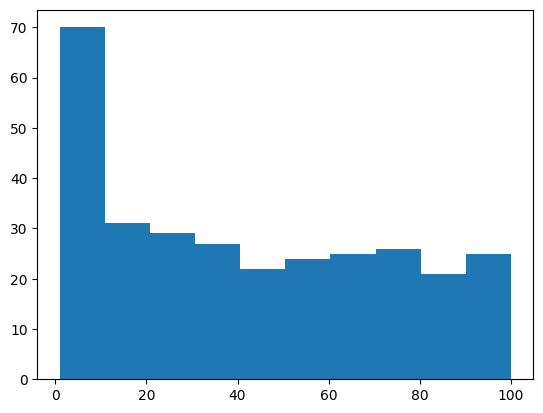

In [16]:
plt.hist(disp_data[0,:,0])